In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data_dir = '/content/drive/MyDrive/data_dir'
train_path = '/content/drive/MyDrive/data_dir/train'
test_path = '/content/drive/MyDrive/data_dir/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [3]:
len(os.listdir(test_path))

12630

In [4]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [5]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry', 19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons'}

Invalid folder: 18


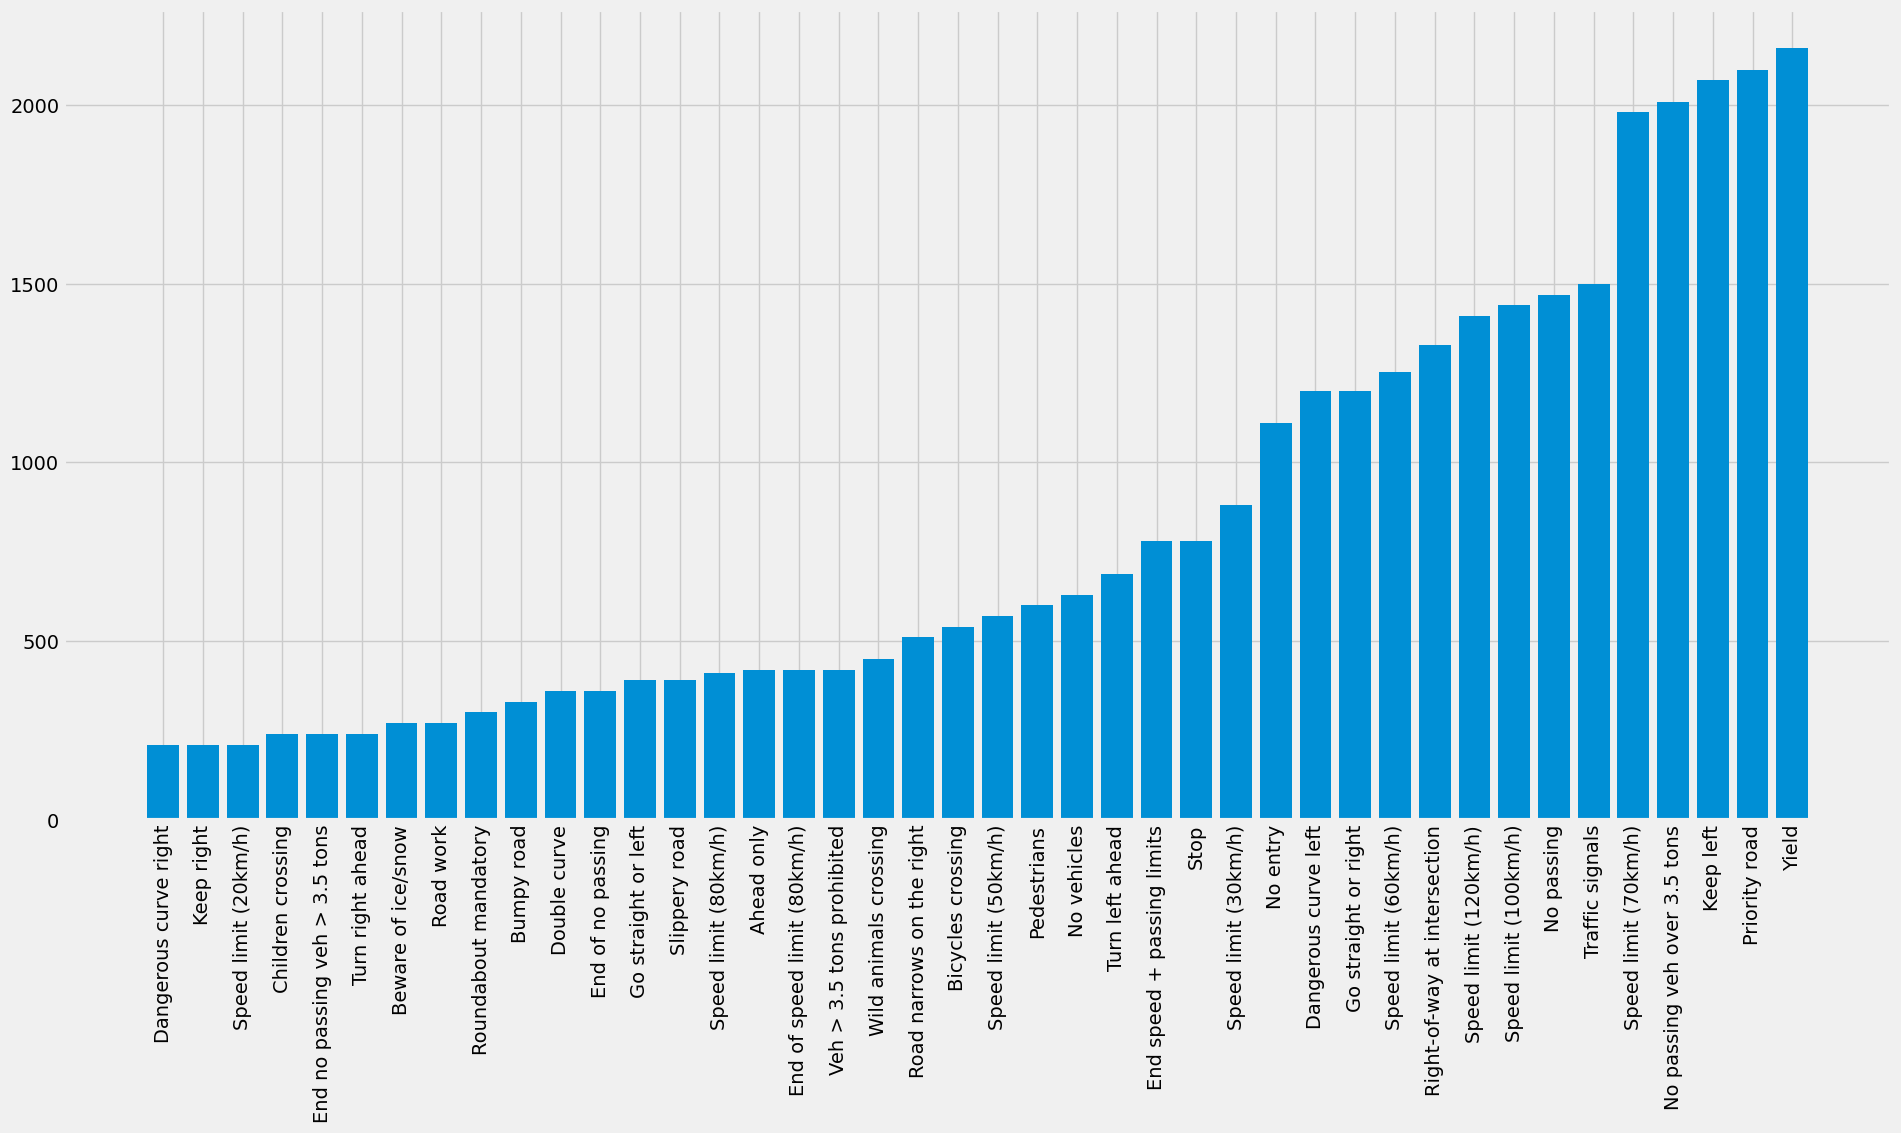

In [6]:
folders = os.listdir(train_path)

train_number = []
class_num = []
for folder in folders:
    # Get a list of files in the current folder
    train_files = os.listdir(train_path + "/" + folder)

    # Append the number of files and class name to the corresponding lists
    train_number.append(len(train_files))
    try:
        class_num.append(classes[int(folder)])
    except KeyError:
        # Handle the case where the folder is not a valid class
        print(f"Invalid folder: {folder}")


# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

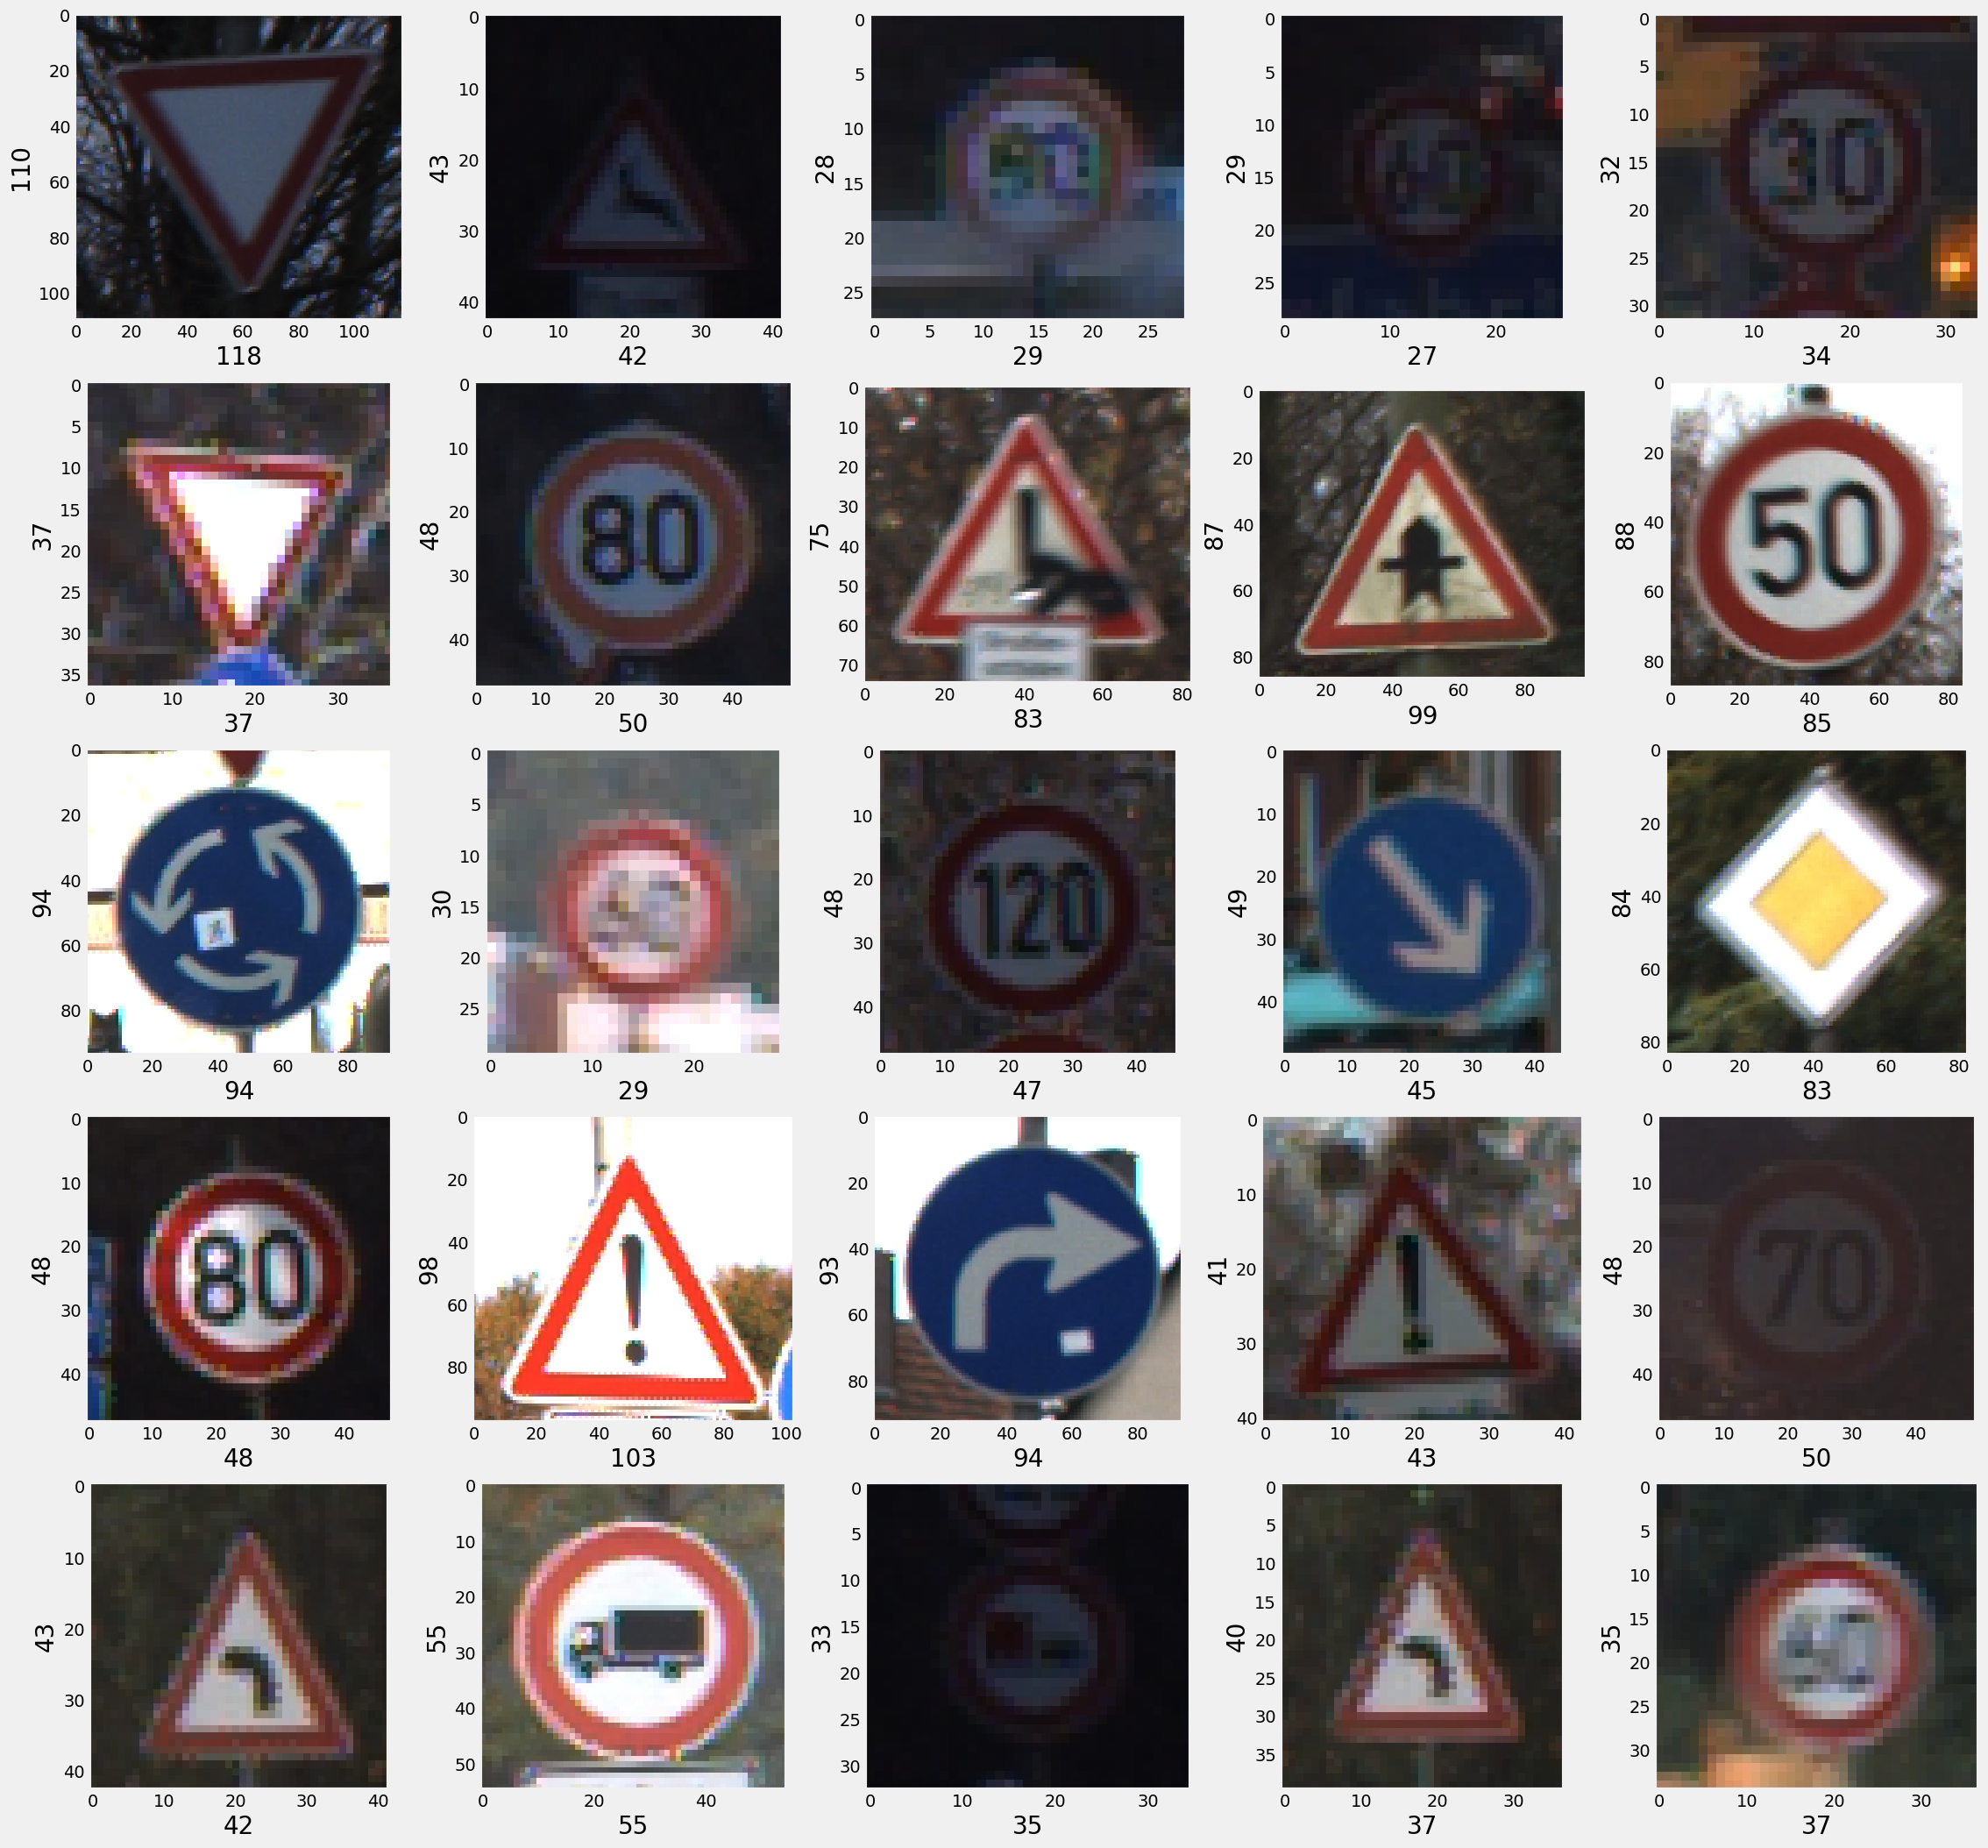

In [7]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    if os.path.exists(random_img_path):
        rand_img = imread(random_img_path)
        plt.imshow(rand_img)
        plt.grid()
        plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
        plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [8]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(34594, 30, 30, 3) (34594,)


In [9]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [10]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (24215, 30, 30, 3)
X_valid.shape (10379, 30, 30, 3)
y_train.shape (24215,)
y_valid.shape (10379,)


In [11]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(24215, 43)
(10379, 43)


In [12]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax'),

])

In [13]:
learning_rate = 0.001
epochs = 20

opt = Adam(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [14]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/20
757/757 [==============================] - 96s 123ms/step - loss: 1.2347 - accuracy: 0.6730 - val_loss: 0.1007 - val_accuracy: 0.9694
Epoch 2/20
757/757 [==============================] - 89s 117ms/step - loss: 0.2238 - accuracy: 0.9308 - val_loss: 0.0579 - val_accuracy: 0.9815
Epoch 3/20
757/757 [==============================] - 93s 123ms/step - loss: 0.1207 - accuracy: 0.9616 - val_loss: 0.0297 - val_accuracy: 0.9909
Epoch 4/20
757/757 [==============================] - 89s 118ms/step - loss: 0.0912 - accuracy: 0.9719 - val_loss: 0.0263 - val_accuracy: 0.9915
Epoch 5/20
757/757 [==============================] - 88s 116ms/step - loss: 0.0767 - accuracy: 0.9772 - val_loss: 0.0259 - val_accuracy: 0.9911
Epoch 6/20
757/757 [==============================] - 91s 120ms/step - loss: 0.0684 - accuracy: 0.9792 - val_loss: 0.0190 - val_accuracy: 0.9938
Epoch 7/20
757/757 [==============================] - 93s 122ms/step - loss: 0.0774 - accuracy: 0.9769 - val_loss: 0.0330 - val_ac

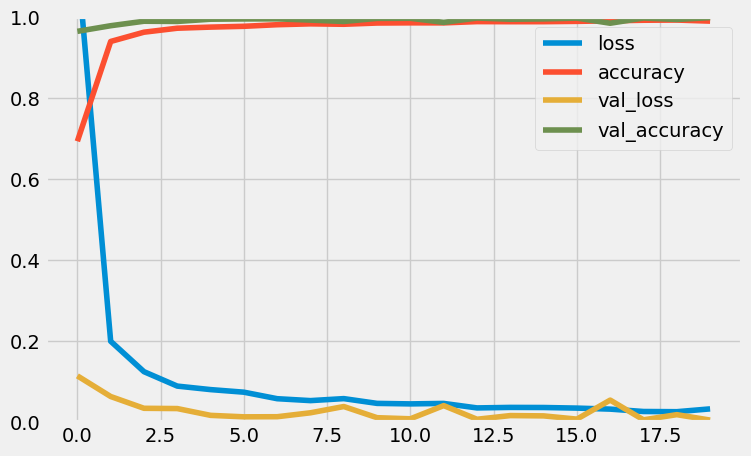

In [ ]:
#Evaluating the model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
pred = model.predict(X_test)

#Accuracy with the test data
pred = np.argmax(pred, axis=1)
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 14s 34ms/step
Test Data accuracy:  97.59303246239112


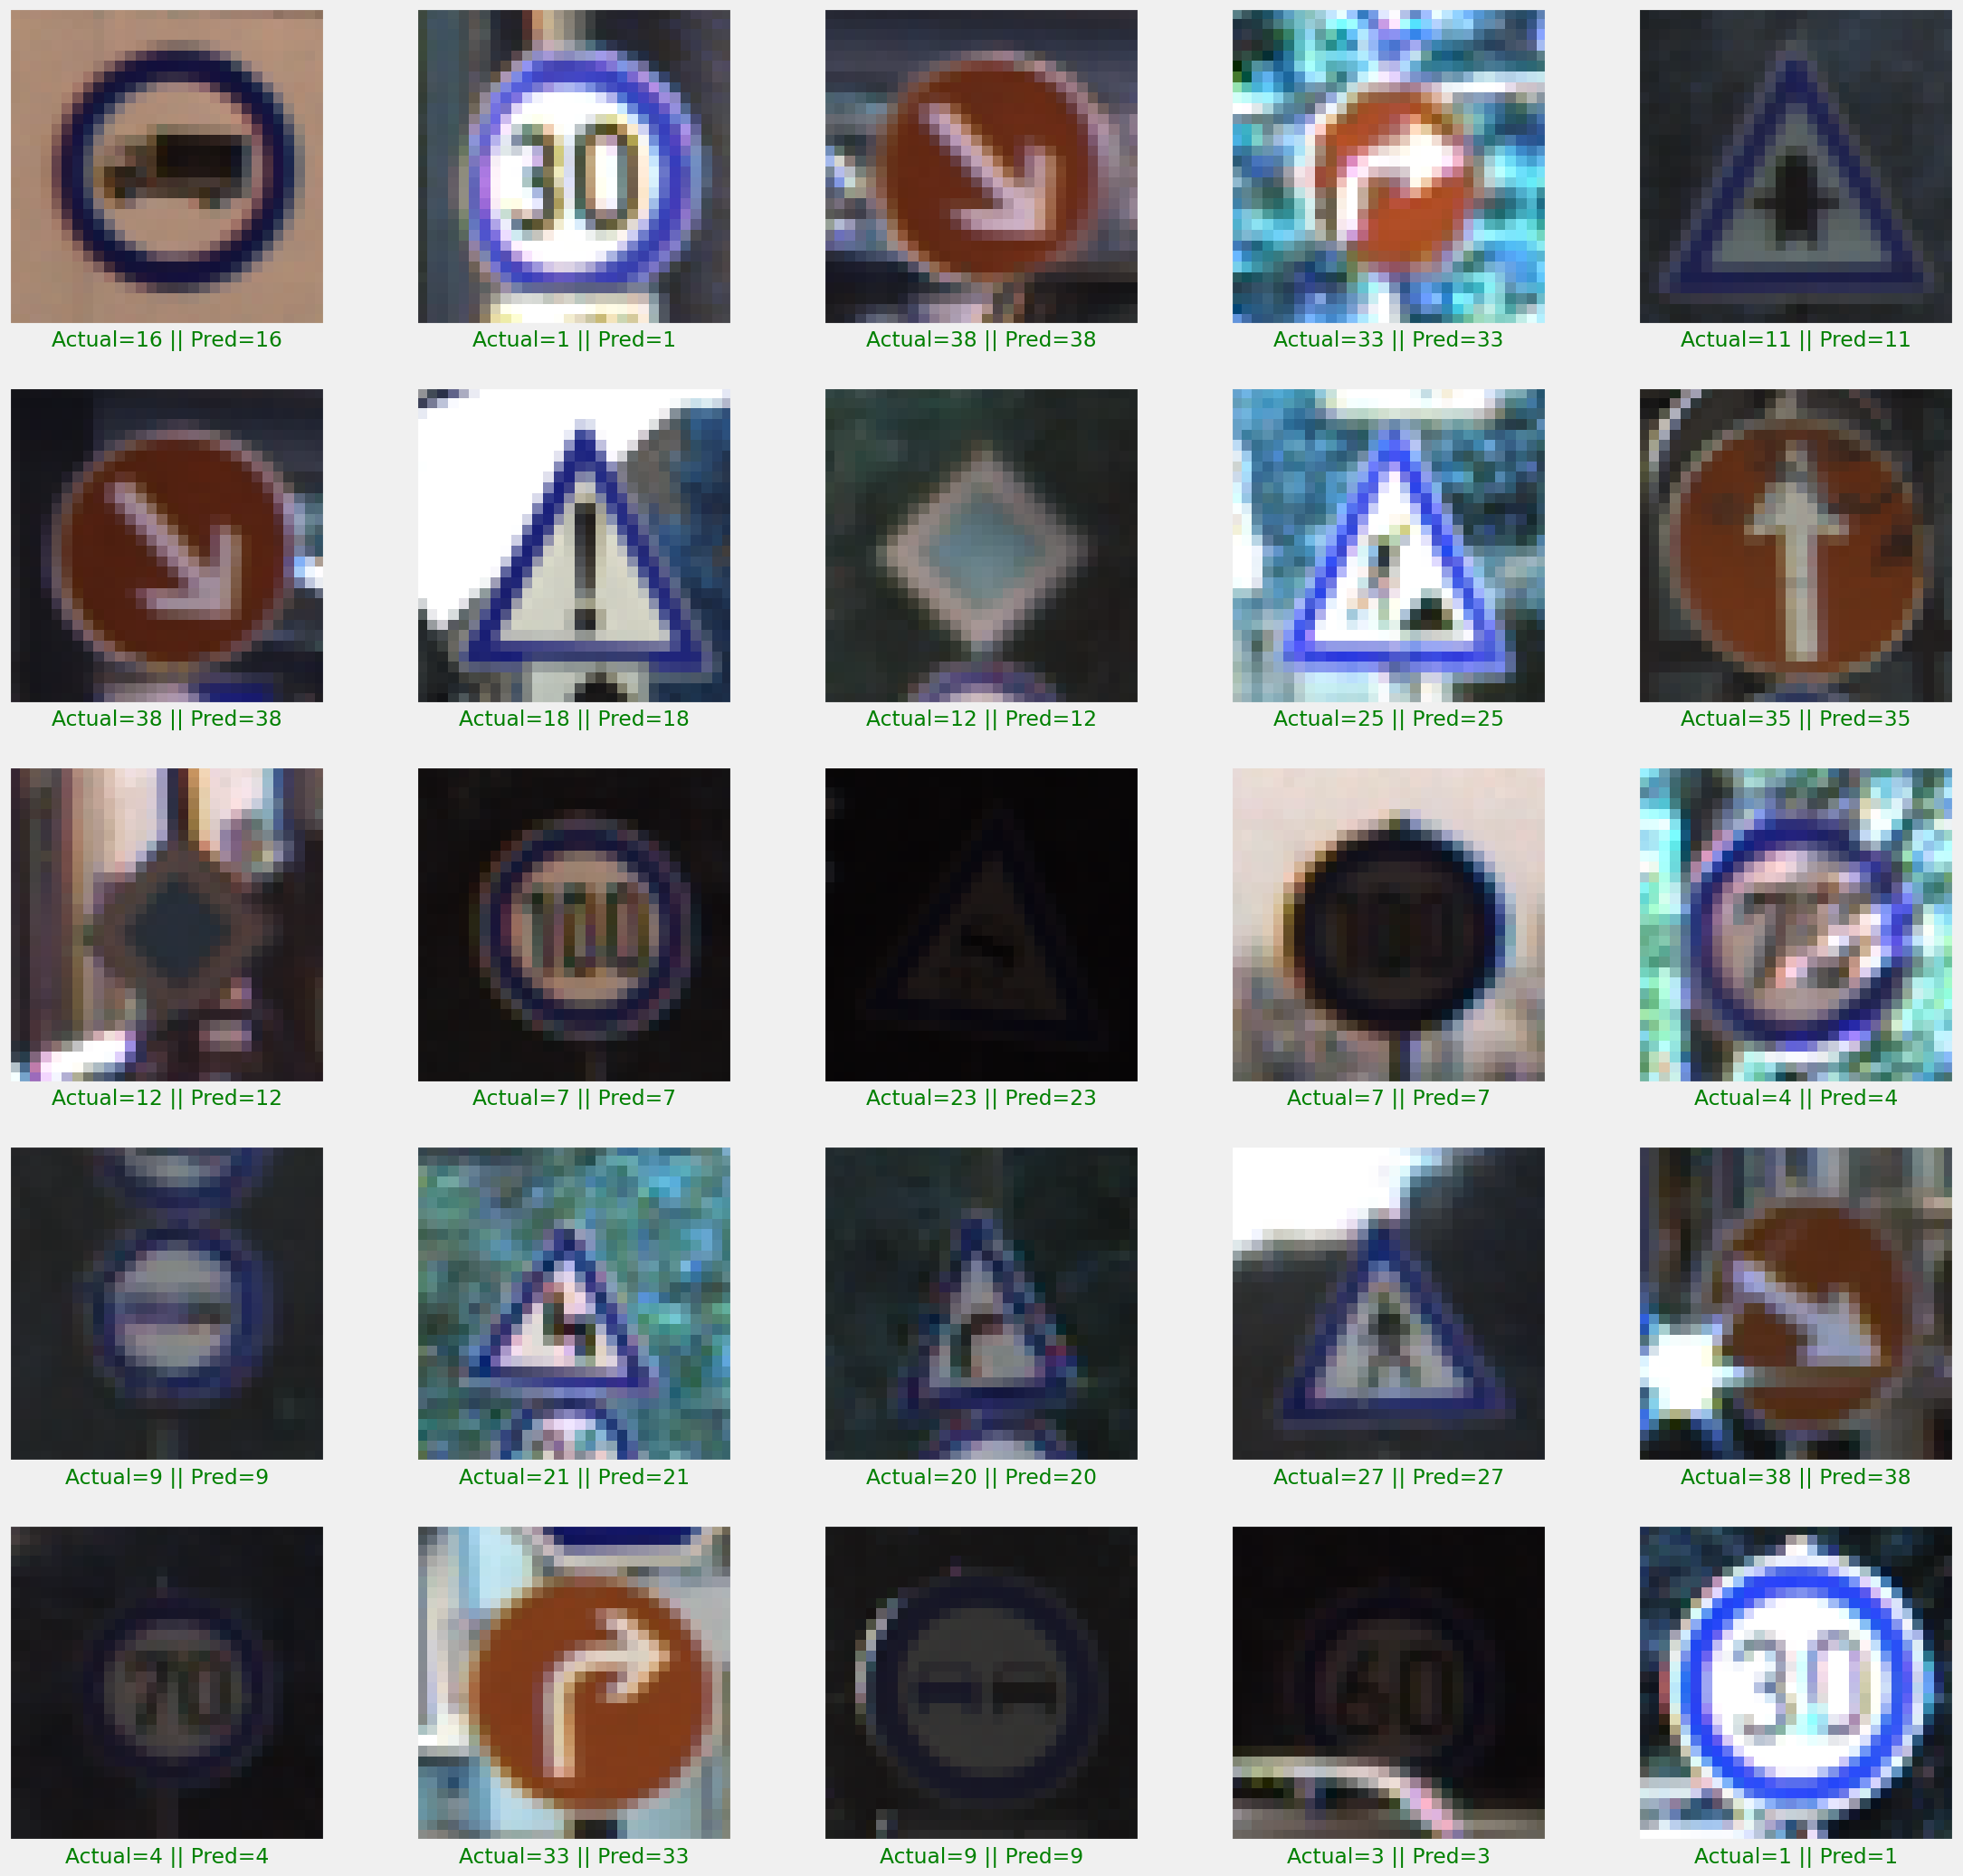

In [ ]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [ ]:
# Assuming 'model' is your trained model
model.save('my_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
